# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two approaches to DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [0]:
!pip install tensorflow-gpu==1.15.2
!wget http://compprag.christopherpotts.net/code-data/swda.zip
!unzip swda.zip

     |████████████████████████████████| 411.0MB 34kB/s 
     |████████████████████████████████| 512kB 65.0MB/s 
     |████████████████████████████████| 3.8MB 55.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=716e98de987dddbb02704c5c316fb46be7a0f5bce26127bb3a051bc4d0a7e847
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc

In [0]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow.compat.v1 as tf
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [0]:
def boost_ram():
  a = []
  while(1):
    a.append('1')

boost_ram()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-87f962e0e46f>", line 6, in <module>
    boost_ram()
  File "<ipython-input-3-87f962e0e46f>", line 4, in boost_ram
    a.append('1')
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/loca

KeyboardInterrupt: ignored

In [0]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [0]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [0]:
reduced_df = result[['act_tag','text']]


Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [0]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [0]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


There are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


To get unique tags:

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [0]:
# Max length of 137
MAX_LENGTH = len(max(sentences, key=len))

In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [0]:
MAX_LENGTH = 137

In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [0]:
#@title Default title text
#Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

In [0]:


train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


# Model 1 - 

The first approach we'll try is to treat DA tagging as a standard multi-class text classification task, in the way you've done before with sentiment analysis and other tasks. Each utterance will be treated independently as a text to be classified with its DA tag label. This model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get the probabilities.


In [0]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 
print('VOCABSIZE: {}, MAX_LENGTH: {}, EMBED_SIZE: {}, HIDDEN_SIZE:{}'.format(VOCAB_SIZE, MAX_LENGTH, EMBED_SIZE, HIDDEN_SIZE))

VOCABSIZE: 43731, MAX_LENGTH: 137, EMBED_SIZE: 100, HIDDEN_SIZE:43


In [0]:
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.compat.v1.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from tensorflow.compat.v1.keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states


model = Sequential()
# Embedding layer
model.add(Embedding(VOCAB_SIZE+1,100, input_length=MAX_LENGTH))
# Bidirectional 1
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
# Bidirectional 2
model.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# Dense layer
model.add(Dense(HIDDEN_SIZE, activation='relu'))
# Activation
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional (Bidirectional (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense (Dense)                (None, 43)                3741      
_________________________________________________________________
activation (Activation)      (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train the model - using validation 
history_model1= model.fit(x=train_input, y=train_labels, validation_data=(val_input,val_labels), epochs=3, verbose=1, batch_size=1000)

Train on 140000 samples, validate on 27704 samples
Epoch 1/3
140000/140000 [==============================] - 140s 1ms/sample - loss: 1.7107 - acc: 0.5713 - val_loss: 1.6181 - val_acc: 0.5972
Epoch 2/3
140000/140000 [==============================] - 140s 999us/sample - loss: 1.4895 - acc: 0.6307 - val_loss: 1.5262 - val_acc: 0.6138
Epoch 3/3
140000/140000 [==============================] - 140s 1ms/sample - loss: 1.4098 - acc: 0.6484 - val_loss: 1.4995 - val_acc: 0.6172


In [0]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 109s 2ms/sample - loss: 1.5079 - acc: 0.6146


In [0]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 61.46112680435181


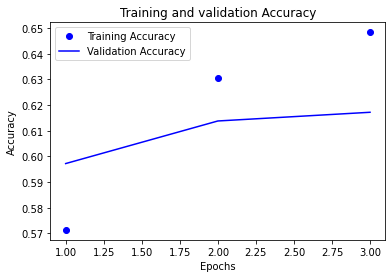

In [0]:
import matplotlib.pyplot as plt

history_dict = history_model1.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Evaluation


The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [0]:
# Generate predictions for the test data
predictions = model.predict(test_sentences_X)

In [0]:
# Build the confusion matrix off these predictions
minority_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(minority_balanced)
class_report = sklearn.metrics.classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(class_report)

[[3281    0    0 ...    0    0    0]
 [  17    0    0 ...    0    0    0]
 [  61    0    0 ...    0    0    0]
 ...
 [  11    0    0 ...    0    0    0]
 [  11    0    0 ...    0    0    0]
 [   8    0    0 ...    0    0    0]]
              precision    recall  f1-score   support

           0       0.37      0.71      0.48      4652
           1       0.00      0.00      0.00       205
           2       0.00      0.00      0.00       170
           3       0.00      0.00      0.00       294
           4       0.94      0.96      0.95       921
           5       0.00      0.00      0.00       178
           6       0.00      0.00      0.00       497
           7       0.00      0.00      0.00        61
           8       0.00      0.00      0.00        22
           9       0.58      0.66      0.62      1249
          10       0.00      0.00      0.00       164
          11       0.00      0.00      0.00        32
          12       0.00      0.00      0.00      4018
          13   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# Calculate Accuracies for "br" and "bf"
bf_index = 19
br_index = 29
print('Summarize/reformulate Accuracy: {}'.format(minority_balanced[bf_index][bf_index]/sum(minority_balanced[bf_index])))
print('Signal-non-understanding Accuracy: {}'.format((minority_balanced[br_index][br_index]/sum(minority_balanced[br_index]))))


Summarize/reformulate Accuracy: 0.0
Signal-non-understanding Accuracy: 0.0



Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




# Model 2 - Balanced Network


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [0]:
# Re-built the model for the balanced training

model = Sequential()
model.add(Embedding(VOCAB_SIZE+1,100, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True)))
model.add(Bidirectional(LSTM(HIDDEN_SIZE)))
model.add(Dense(HIDDEN_SIZE, activation='relu'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 137, 100)          4373200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_1 (Activation)    (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train the balanced network -  takes  time to achieve good accuracy
history_model2 =model.fit(x=train_input, y=train_labels, validation_data=(val_input,val_labels), epochs=20, verbose=1, class_weight=d_class_weights, batch_size=1000)

Train on 140000 samples, validate on 27704 samples
Epoch 1/20
140000/140000 [==============================] - 143s 1ms/sample - loss: 3.2296 - acc: 0.1179 - val_loss: 2.9466 - val_acc: 0.1287
Epoch 2/20
140000/140000 [==============================] - 141s 1ms/sample - loss: 2.7678 - acc: 0.2764 - val_loss: 2.5037 - val_acc: 0.2931
Epoch 3/20
140000/140000 [==============================] - 140s 1ms/sample - loss: 2.4522 - acc: 0.3401 - val_loss: 2.5303 - val_acc: 0.3198
Epoch 4/20
140000/140000 [==============================] - 140s 1ms/sample - loss: 2.1761 - acc: 0.3870 - val_loss: 2.3202 - val_acc: 0.3327
Epoch 5/20
140000/140000 [==============================] - 140s 1ms/sample - loss: 1.9814 - acc: 0.4025 - val_loss: 2.1593 - val_acc: 0.3874
Epoch 6/20
140000/140000 [==============================] - 140s 1ms/sample - loss: 1.7835 - acc: 0.4329 - val_loss: 2.1350 - val_acc: 0.3636
Epoch 7/20
140000/140000 [==============================] - 140s 1000us/sample - loss: 1.6496 - a

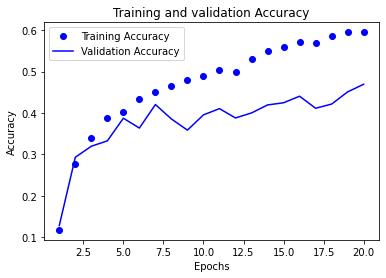

In [0]:
history_dict = history_model2.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Test the model

In [0]:
# Overall Accuracy
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 109s 2ms/sample - loss: 1.8296 - acc: 0.4725


In [0]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 47.2469687461853


In [0]:
# Generate predictions for the test data
label_pred = model.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [0]:
# Build the confusion matrix off these predictions

matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

balanced_class_report = sklearn.metrics.classification_report(y_test.argmax(axis=1), label_pred.argmax(axis=1))
print(balanced_class_report)
# Calculate Accuracies for "br" and "bf"
print('Summarize/reformulate Accuracy: {}'.format(matrix_balanced[bf_index][bf_index]/sum(matrix_balanced[bf_index])))
print('Signal-non-understanding Accuracy: {}'.format((matrix_balanced[br_index][br_index]/sum(matrix_balanced[br_index]))))


              precision    recall  f1-score   support

           0       0.56      0.46      0.51      4652
           1       0.04      0.27      0.07       205
           2       0.08      0.14      0.10       170
           3       0.24      0.68      0.36       294
           4       0.00      0.00      0.00       921
           5       0.10      0.36      0.16       178
           6       0.60      0.62      0.61       497
           7       0.37      0.67      0.48        61
           8       0.04      0.32      0.06        22
           9       0.57      0.64      0.60      1249
          10       0.55      0.54      0.54       164
          11       0.00      0.00      0.00        32
          12       0.77      0.71      0.74      4018
          13       0.91      0.64      0.75      9524
          14       0.10      0.36      0.15        90
          15       0.64      0.43      0.51      1209
          16       0.77      0.42      0.55     18801
          17       0.03    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




### Accuracies



### Explanation


### Other ways to handle imbalanced classes


- Remove samples from the majority classes to balance out the inbalanced dataset.

- Utilise a generative model to produce samples of the minority classes using those classes' probability disitributions to balance out the imbalanced dataset. 

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification

The second approach we will try is a hierarchical approach to DA tagging. We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification, acting like the text classifier from Model 1 above. Then we use a bidirectional-LSTM (BLSTM) above that to learn how to use the context before and after the current utterance to improve the output.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output



## CNN


This is a classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [0]:
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input, Embedding, Reshape, Conv2D, BatchNormalization, MaxPool2D, Concatenate, Flatten, Dense, Dropout, TimeDistributed
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
conc = Concatenate()([maxpool_0, maxpool_1, maxpool_2])
# flatten concatenated tensors
flat = TimeDistributed(Flatten())(conc)
# dense layer (dense_1)
s = np.shape(flat)
dense_1 = Dense(100, activation='relu')(flat)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.

In [0]:
from tensorflow.compat.v1.keras.layers import Bidirectional, LSTM
# BLSTM model
ds = np.shape(dropout_1)

# Bidirectional 1u
bi_1 = Bidirectional(LSTM(100, return_sequences=True))(dropout_1)

# Bidirectional 2
b1s = np.shape(bi_1)
bi_2 = Bidirectional(LSTM(100))(bi_1)

# Dense layer (dense_2)
b2s = np.shape(bi_2)
dense_2 = Dense(100, activation='relu')(bi_2)

# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer

In [0]:
# concatenate 2 final layers
dropout_1_flat = Flatten()(dropout_1)
final_conc = Concatenate()([dropout_1_flat,dropout_2])
# output
output = Dense(43, activation='softmax')(final_conc)

cnn_model = Model(inputs=[inputs], outputs=[output])
cnn_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 137)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 137, 100)     4373200     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 137, 100, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 135, 1, 64)   19264       reshape[0][0]                    
______________________________________________________________________________________________

Train on 140000 samples, validate on 27704 samples
Epoch 1/4
140000/140000 [==============================] - 9s 67us/sample - loss: 0.4912 - acc: 0.8454 - val_loss: 1.0355 - val_acc: 0.7015
Epoch 2/4
140000/140000 [==============================] - 9s 67us/sample - loss: 0.4389 - acc: 0.8596 - val_loss: 1.1532 - val_acc: 0.6917
Epoch 3/4
140000/140000 [==============================] - 9s 68us/sample - loss: 0.4017 - acc: 0.8693 - val_loss: 1.2731 - val_acc: 0.6952
Epoch 4/4
140000/140000 [==============================] - 9s 67us/sample - loss: 0.3810 - acc: 0.8754 - val_loss: 1.3132 - val_acc: 0.6913


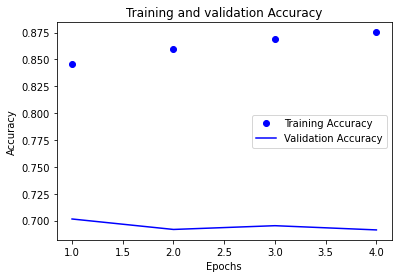

In [0]:
# Train the model - using validation 
cnn_history = cnn_model.fit(x=train_input, y=train_labels, validation_data=(val_input,val_labels), epochs=4, verbose=1, batch_size=1000)


acc = cnn_history.history['acc']
val_acc = cnn_history.history['val_acc']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
score = cnn_model.evaluate(test_sentences_X, y_test, batch_size=100)
label_pred = model.predict(test_sentences_X, batch_size=100)

55902/55902 [==============================] - 3s 53us/sample - loss: 1.3202 - acc: 0.6920


In [0]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 69.20324563980103


In [0]:
cnn_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))
bf_index = 19
br_index = 29
cnn_class_report = sklearn.metrics.classification_report(y_test.argmax(axis=1), label_pred.argmax(axis=1))
print(cnn_class_report)
# Calculate Accuracies for "br" and "bf"
print('Summarize/reformulate Accuracy: {}'.format(cnn_matrix[bf_index][bf_index]/sum(cnn_matrix[bf_index])))
print('Signal-non-understanding Accuracy: {}'.format((cnn_matrix[br_index][br_index]/sum(cnn_matrix[br_index]))))

              precision    recall  f1-score   support

           0       0.01      0.08      0.01       261
           1       0.00      0.00      0.00       775
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       220
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00       188
           6       0.00      0.00      0.00       917
           7       0.00      0.00      0.00       189
           8       0.00      0.00      0.00       239
           9       0.00      0.00      0.00     18909
          10       0.00      0.00      0.00       169
          11       0.00      0.01      0.00      1216
          12       0.00      0.00      0.00       147
          13       0.00      0.00      0.00        78
          14       0.01      0.57      0.01       296
          15       0.00      0.00      0.00        19
          16       0.00      0.00      0.00        49
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Report** your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




### Minority Classes



# Advanced:  Bert-Based Model for Dialogue Act Tagging

In the last section we want to use BERT and leverage contextual word embeddings, following on from the last lab you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. You could use your BERT-based text classifier here (instead of the CNN utterance-level classifier) and see if a pre-trained BERT language model helps. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on DA tagging.

In [0]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
import sklearn
# Initialize session
sess = tf.Session()
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 256
labels = reduced_df['act_tag']
train_text, test_text, train_label, test_label = train_test_split(np.array(sentences), labels)


In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  
  """


class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():

    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Task 1
# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()
# Convert data to InputExample format
InputExamplesTrain=convert_text_to_examples(train_text,train_label)
InputExamplesTest=convert_text_to_examples(test_text,test_label)
# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels) = convert_examples_to_features(tokenizer, InputExamplesTrain)
(test_input_ids, test_input_masks, test_segment_ids, test_labels) = convert_examples_to_features(tokenizer, InputExamplesTest)

train_labels = sklearn.preprocessing.OneHotEncoder().fit_transform(train_labels)
test_labels = sklearn.preprocessing.OneHotEncoder().fit_transform(test_labels)
# End of Task 1

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
# Task 2
# Build model

input_ids = tf.keras.layers.Input((max_seq_length,), dtype='float32', name='IDInput')
input_masks = tf.keras.layers.Input((max_seq_length,), dtype='float32', name='MASKSInput')
input_segment_ids = tf.keras.layers.Input((max_seq_length,), dtype='float32', name='SEGMENTIDInput')
major_input = [input_ids, input_masks, input_segment_ids]
bert = BertLayer(n_fine_tune_layers=1)(major_input)
output = tf.keras.layers.Dense(43, activation='softmax')(bert)

model = tf.keras.models.Model(inputs=[major_input], outputs = [output])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# End of Task 2


def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:

# Instantiate variables
initialize_vars(sess)

#print(type(train_input_ids), type(train_input_masks), type(train_segment_ids), type(train_labels))
#print(np.shape(train_input_ids), np.shape(train_input_masks), np.shape(train_segment_ids), np.shape(train_labels))

bert_model_hist = model.fit([train_input_ids, train_input_masks, train_segment_ids], train_labels,validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels), epochs=1, batch_size=32)

Train on 167704 samples, validate on 55902 samples
167704/167704 [==============================] - 8556s 51ms/sample - loss: 0.9997 - acc: 0.6988 - val_loss: 0.8836 - val_acc: 0.7261


In [0]:
score = model.evaluate([test_input_ids, test_input_masks, test_segment_ids], test_labels, batch_size=32)
label_pred = model.predict([test_input_ids, test_input_masks, test_segment_ids], batch_size=32)
print("Overall Accuracy:", score[1]*100)

55902/55902 [==============================] - 1940s 35ms/sample - loss: 0.8836 - acc: 0.7261
Overall Accuracy: 72.60921001434326


In [0]:

#print(label_pred.argmax())
#bert_matrix = sklearn.metrics.confusion_matrix(test_label.argmax(), label_pred.argmax(axis=1))
bf_index = 19 #rerun cell
br_index = 29
bert_class_report = sklearn.metrics.classification_report(test_labels.argmax(axis=1), label_pred.argmax(axis=1))
print(bert_class_report)
# Calculate Accuracies for "br" and "bf"
#print('Summarize/reformulate Accuracy: {}'.format(bert_matrix[bf_index][bf_index]/sum(bert_matrix[bf_index])))
#print('Signal-non-understanding Accuracy: {}'.format((bert_matrix[br_index][br_index]/sum(bert_matrix[br_index]))))

2312175
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      3922
           1       0.75      0.71      0.73      4592
           2       0.00      0.00      0.00       181
           3       0.36      0.33      0.35        27
           4       0.86      0.36      0.50       152
           5       0.00      0.00      0.00       252
           6       0.62      0.26      0.36      2755
           7       0.00      0.00      0.00        23
           8       0.63      0.13      0.22       180
           9       0.00      0.00      0.00        94
          10       0.00      0.00      0.00        53
          11       0.75      0.94      0.84      9435
          12       0.12      0.14      0.13       175
          13       0.78      0.61      0.69      1211
          14       0.00      0.00      0.00        21
          15       0.00      0.00      0.00       248
          16       0.80      0.70      0.74       250
          17       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: ignored

In [0]:
for i in range(15):
  print(sentences[i])
  print('Label:')
  print(test_labels[i])
  print('Prdicted:')
  print(np.array(label_pred[i]).argmax())
  print('--------------------------------------------------')
  print('--------------------------------------------------')
  print('--------------------------------------------------')

['<Throat_clearing>', '[', 'I', 'guess,', '+', 'I', 'guess', '', ']', 'by', 'what', 'you', 'said', '', '[', "you're,", '+', '', 'you', '', "don't", ']', 'feel', 'your,', '', '', '{F', 'uh,', '}', 'privacy', 'has', 'been', '[', 'inva-,', '+', 'invaded', ']', 'anytime', 'recently?', '/']
Label:
  (0, 39)	1.0
Prdicted:
38
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
['No,', '', '/']
Label:
  (0, 38)	1.0
Prdicted:
38
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
['not', 'really.', '', '/']
Label:
  (0, 38)	1.0
Prdicted:
0
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
['{F', 'Uh,', '}', '[', '[', '', '{F', 'u-,', '}', 'th-,', '', '+', '{F', 'uh,', '}', 'th-,', ']', '+', 'the